# Microsoft Movie Studio Business Analysis

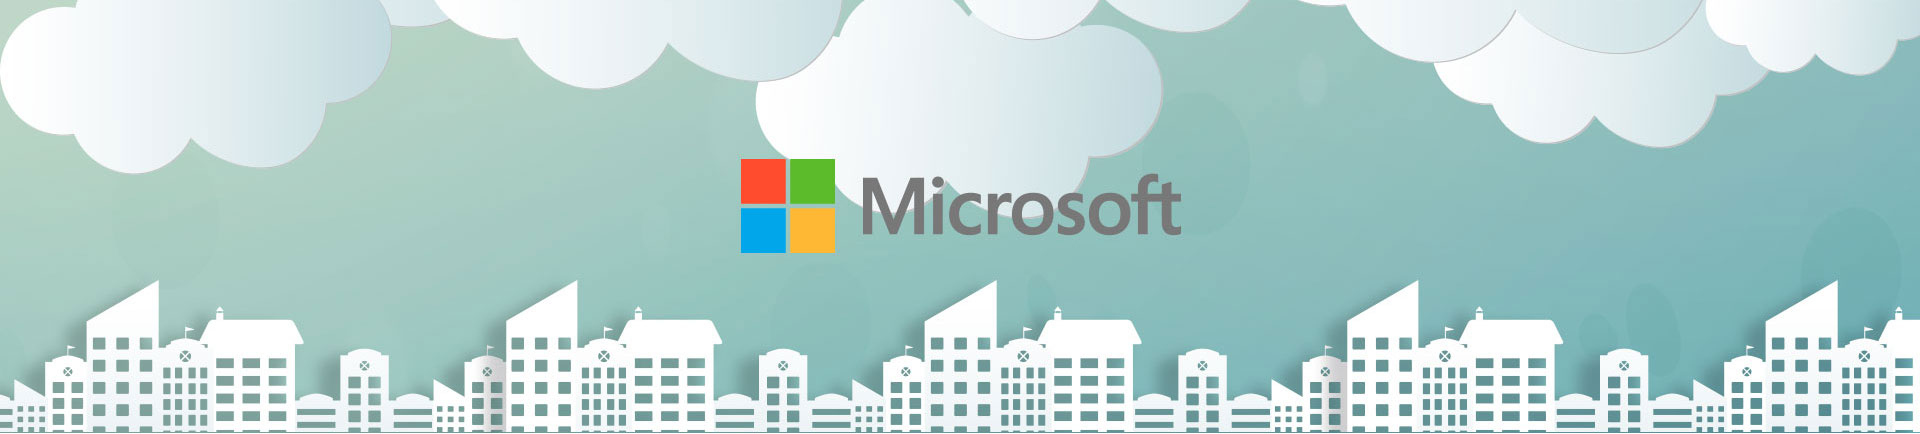

## Overview

Microsoft wants to launch a new movie studio, and there are important factors to consider for optimizing profits.

By analyzing historical data, we uncovered data-driven tips for ensuring a production is high performing with an efficient return on investment.

## Business Problem

Microsoft does not know anything about creating movies, yet they want to create a new movie studio.

There are many unknown factors associated with how to make a profit.

* *How long should the films be?*
* *What genre should Microsoft produce?*
* *Should Microsoft start from scratch or acquire a studio?*

Using the data provided and additional resources, we devised a plan to answer these questions about how best Microsoft can break into the movie studio market and ensure profitability.

## Data Understanding

We are using movie datasets from 4 different sources:

 - IMDb
 - TheMovieDB
 - Box Office Mojo
 - The Numbers

The data includes information on movie genres, titles, runtime, production expense, foreign & domestic box office gross, production studio name, and release dates.

With these datasets, we will search for insights in box office performence and user ratings compared to various factors like genre, personnel, runtime, production budget and release time.

In [1]:
import pandas as pd
import numpy as np

In [2]:
box_mojo_df = pd.read_csv('data/bom.movie_gross.csv')
numbers_df = pd.read_csv('data/tn.movie_budgets.csv')
title_basics_df = pd.read_csv('data/imdb.title.basics.csv')
name_basics_df = pd.read_csv('data/imdb.name.basics.csv')
crew_df = pd.read_csv('data/imdb.title.crew.csv')
principal_df = pd.read_csv('data/imdb.title.principals.csv')
ratings_df = pd.read_csv('data/imdb.title.ratings.csv')
tmdb_df = pd.read_csv('data/tmdb.movies.csv')

## Data Preparation

Out of the available datasets, IMDb is the largest, with useful data on runtime, genres, and personnel. It's also more convenient to select which of these values we'd like to look at, as each data set has a `tconst` column that allows them to be stitched together. For this reason, it would more helpful if IMDb had associated financial information that would allow a broader dataset to draw conclusions from. Unfortunately, IMDb lacks box office or budget data, so it needs to be merged with The Numbers, Box Office Mojo or TheMovieDB data set. These four are collectively the most useful and what we'll be basing our recommendations on. 

### Data Cleaning

In [3]:
# Organizing the imdb data for runtime analysis. Extracts columns needed to merge and the runtime data.
tb_df = title_basics_df[['primary_title', 'start_year', 'runtime_minutes']]

# Filter out movies that haven't been made yet, and those we don't have runtime data for.
tb_df = tb_df[tb_df['start_year'] < 2022]
tb_df = tb_df.dropna(axis=0, subset=['runtime_minutes'])
tb_df.head()

,primary_title,start_year,runtime_minutes
0,Sunghursh,2013,175.0
1,One Day Before the Rainy Season,2019,114.0
2,The Other Side of the Wind,2018,122.0
4,The Wandering Soap Opera,2017,80.0
5,A Thin Life,2018,75.0


In [4]:
# We change the year data to match the IMDB format of only the year number.
numbers_df['release_date'] = pd.to_datetime(numbers_df['release_date'])
numbers_df['release_year'] = numbers_df['release_date'].dt.year
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'])
tmdb_df['release_year'] = tmdb_df['release_date'].dt.year

# Create a Month DateTime column of the release dates
numbers_df['month_dt'] = pd.to_datetime(numbers_df['release_date']).dt.month

# Create a Month string column of the release dates
numbers_df['month'] = numbers_df['release_date'].dt.month
numbers_df = numbers_df.drop('release_date', 1)

In [5]:
# Converting to integer types for visualizations later
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
numbers_df[cols] = numbers_df[cols].replace('[\$,]', '', regex=True).astype('int64')

In [6]:
# Title case all title data to have a better chance of matching in the merge.
tb_df['primary_title'] = tb_df['primary_title'].str.title()
numbers_df['movie'] = numbers_df['movie'].str.title()
box_mojo_df['title'] = box_mojo_df['title'].str.title()
tmdb_df['title'] = tmdb_df['title'].str.title()

In [7]:
# Adding profit margin columns
numbers_df['dom_profit_margin'] = (numbers_df['domestic_gross'] - numbers_df['production_budget']) / numbers_df['domestic_gross'] * 100 
numbers_df['ww_profit_margin'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget']) / numbers_df['worldwide_gross'] * 100

In [8]:
# Adding a column 'world_wide_profit_amount' that is the worldwide gross minus the production budget
numbers_df['world_wide_profit_amount'] = (numbers_df['worldwide_gross'] - numbers_df['production_budget'])

# Adding a ROI column that is the net profit amount divided by production budget. ROI = net / expense 
numbers_df['ROI_perc'] = (numbers_df['world_wide_profit_amount']  / numbers_df['production_budget']) * 100

In [9]:
# Making numbers_df only the years after 2000
numbers_df = numbers_df[numbers_df['release_year'] > 2000]

In [10]:
# Create a new data frame grouped by months and their median values.
month_df = numbers_df.groupby('month').median()

# Reset the index
month_df = month_df.reset_index()

# Sort the months in order
month_df = month_df.sort_values('month_dt')

# Add the names of the month
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', \
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_df['month_name'] = month_dict.values() 

### Merging Datasets

Merging The Numbers data set and Imdb for runtime and box office gross comparisons.

In [11]:
# Merge on title and year to avoid incorrect matches on movies that have the same name.
numbers_and_tb = numbers_df.merge(tb_df,left_on=['movie', 'release_year'],right_on=['primary_title', 'start_year'],how='inner')
numbers_and_tb = numbers_and_tb.loc[numbers_and_tb['domestic_gross'] > 0]

In [12]:
# Creating dataframe with studio and box office data 
studio_df = box_mojo_df[['title', 'studio', 'year']].merge(numbers_df, left_on=['title', 'year'], right_on=['movie', 'release_year'])

In [13]:
# Group by studio of studio_df
avg_studio = studio_df.groupby('studio').mean().reset_index()
avg_studio = avg_studio[avg_studio['dom_profit_margin'] > 0]

In [14]:
# Merge The Numbers and Tmdb to get box office and budget together with genres
genre_df = numbers_df.merge(tmdb_df, left_on=['movie', 'release_year'], right_on=['title', 'release_year'])
genre_df.loc[:,'genre_ids'] = genre_df['genre_ids'].map(lambda genre_string: genre_string.strip('[]').split(', '))
genre_df = genre_df.loc[(genre_df['worldwide_gross'] > 0) & (genre_df['domestic_gross'] > 0)]
genre_ids_df = genre_df.explode('genre_ids')

# Genre key for ids in Tmdb
genre_converter = pd.read_csv('data/genre_list.csv')
genre_converter['id'] = genre_converter['id'].astype('str')
genre_converter.rename(columns={"id": "genre_ids", "name": "genre_name"}, inplace=True)
genre_overall = genre_ids_df.merge(genre_converter, on="genre_ids")

In [15]:
# Grouping genre_overall by the mean of each genre name and sorting by 'ROI_perc'
genre_groups = genre_overall.groupby('genre_name').mean()
genre_groups = genre_groups.sort_values('ROI_perc', ascending=False)[:7]

In [16]:
# Grouping genre_overall by the median of each genre name and sorting by 'ROI_perc'
genre_groups_med = genre_overall.groupby('genre_name').median()
genre_groups_med = genre_groups_med.sort_values('ROI_perc', ascending=False)[:7]

In [17]:
# Creating dataframe the groups by genre only for movies with Horror genre
horror_month_df = genre_overall[genre_overall['genre_name'] == 'Horror']
horror_month_df = horror_month_df[horror_month_df['worldwide_gross'] > 100000]
horror_month_df = horror_month_df.groupby('month').median()
horror_month_df = horror_month_df.reset_index()
horror_month_df = horror_month_df.sort_values('month_dt')
horror_month_df['month_name'] = month_dict.values() 

In [18]:
# OVERVIEW OF THE DESCRIPTIVE ANALYSIS OF THE DATAFRAMES WE WILL USE FOR ANALYSIS
display(horror_month_df.describe())
display(avg_studio.describe())
display(genre_overall.describe())

,month,id_x,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc,Unnamed: 0,id_y,popularity,vote_average,vote_count
count,12.000000,12.000000,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,52.333333,1.225000e+07,2.967463e+07,6.444484e+07,2014.375000,6.500000,29.854617,72.309285,4.475456e+07,354.721341,12872.583333,196579.541667,12.258125,5.891667,1269.708333
std,3.605551,13.499719,7.981513e+06,1.267051e+07,2.953579e+07,1.130668,3.605551,44.376370,11.857054,2.391774e+07,268.683956,3292.982807,84748.474248,2.011535,0.359819,569.857616
min,1.000000,29.000000,5.000000e+06,6.810754e+06,8.890094e+06,2012.500000,1.000000,-46.826622,46.644106,5.482387e+06,87.420720,6696.000000,78689.500000,9.417000,5.300000,465.000000
25%,3.750000,40.500000,9.000000e+06,2.127689e+07,4.609280e+07,2013.875000,3.750000,-2.734314,67.986007,2.640324e+07,215.755023,11109.750000,131837.875000,10.762500,5.650000,1039.750000
50%,6.500000,53.500000,1.050000e+07,3.137490e+07,7.166126e+07,2014.000000,6.500000,44.938645,74.487542,4.105084e+07,299.898476,12685.000000,195966.000000,12.056250,6.050000,1136.250000
75%,9.250000,60.500000,1.312500e+07,3.522970e+07,8.241241e+07,2015.125000,9.250000,60.494987,78.652243,6.035616e+07,390.501129,14654.625000,275652.250000,13.566625,6.125000,1421.750000
max,12.000000,72.000000,3.500000e+07,4.959554e+07,1.050150e+08,2016.000000,12.000000,86.396271,91.746503,8.024575e+07,1112.211863,17580.000000,307986.000000,15.259000,6.300000,2764.000000


,year,id,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc
count,14.000000,14.000000,1.400000e+01,1.400000e+01,1.400000e+01,14.000000,14.000000,14.000000,14.000000,14.000000,1.400000e+01,14.000000
mean,2014.184938,49.006175,2.756587e+07,4.143936e+07,9.974835e+07,2014.184938,6.353598,6.353598,34.775649,66.245899,7.218248e+07,476.523624
std,2.424399,19.496003,3.708456e+07,4.761739e+07,1.369205e+08,2.424399,1.950358,1.950358,22.123616,13.546435,1.002492e+08,371.478565
min,2010.000000,3.000000,2.500000e+06,3.827060e+06,1.323772e+07,2010.000000,4.000000,4.000000,1.574618,46.833530,6.704317e+06,205.213397
25%,2012.120352,44.925000,3.875000e+06,9.457203e+06,1.593061e+07,2012.120352,5.045455,5.045455,19.559690,54.784204,1.235140e+07,243.356975
50%,2014.102564,52.815068,9.325000e+06,2.260992e+07,4.436142e+07,2014.102564,6.153846,6.153846,34.276450,67.147950,3.079324e+07,320.355018
75%,2016.375000,56.990909,3.841071e+07,6.946566e+07,1.260143e+08,2016.375000,6.925000,6.925000,50.476864,75.044508,8.760357e+07,555.441756
max,2017.500000,83.000000,1.334000e+08,1.682915e+08,5.078028e+08,2017.500000,12.000000,12.000000,68.518543,89.515856,3.744028e+08,1574.515218


,id_x,production_budget,domestic_gross,worldwide_gross,release_year,month_dt,month,dom_profit_margin,ww_profit_margin,world_wide_profit_amount,ROI_perc,Unnamed: 0,id_y,popularity,vote_average,vote_count
count,4133.000000,4.133000e+03,4.133000e+03,4.133000e+03,4133.000000,4133.000000,4133.000000,4.133000e+03,4133.000000,4.133000e+03,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000,4133.000000
mean,50.804984,5.533228e+07,6.931336e+07,1.793189e+08,2013.830873,7.046213,7.046213,-4.821940e+03,-604.132038,1.239867e+08,290.434155,11501.956448,191757.458505,14.125619,6.396226,2563.036777
std,28.479926,6.134346e+07,9.613733e+07,2.690121e+08,2.729707,3.453682,3.453682,7.580398e+04,5258.912012,2.236072e+08,1084.758057,7794.608566,137361.519208,8.213696,0.799567,3129.956428
min,1.000000,3.000000e+04,3.880000e+02,5.280000e+02,2001.000000,1.000000,1.000000,-3.267874e+06,-94596.969697,-1.104502e+08,-99.894400,1.000000,176.000000,0.600000,2.500000,1.000000
25%,27.000000,1.180000e+07,8.574339e+06,1.819083e+07,2012.000000,4.000000,4.000000,-1.250135e+02,11.032429,1.360665e+06,12.400506,5198.000000,62177.000000,8.961000,5.900000,477.000000
50%,50.000000,3.200000e+07,3.560824e+07,7.496685e+07,2014.000000,7.000000,7.000000,-1.763394e+00,57.375157,3.674214e+07,134.604971,11132.000000,166424.000000,12.408000,6.400000,1365.000000
75%,75.000000,7.900000e+07,8.502819e+07,2.165623e+08,2016.000000,10.000000,10.000000,4.630450e+01,75.748341,1.379036e+08,312.342922,17581.000000,308531.000000,17.021000,6.900000,3412.000000
max,100.000000,4.250000e+08,7.605076e+08,2.776345e+09,2019.000000,12.000000,12.000000,9.956072e+01,99.759941,2.351345e+09,41556.474000,25148.000000,547590.000000,80.773000,10.000000,22186.000000


## Analysis

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_context('poster')
sns.set_style('darkgrid')

### Runtime Frequency
The graph below shows the frequency of movies by runtime given they have a ROI over 50%.

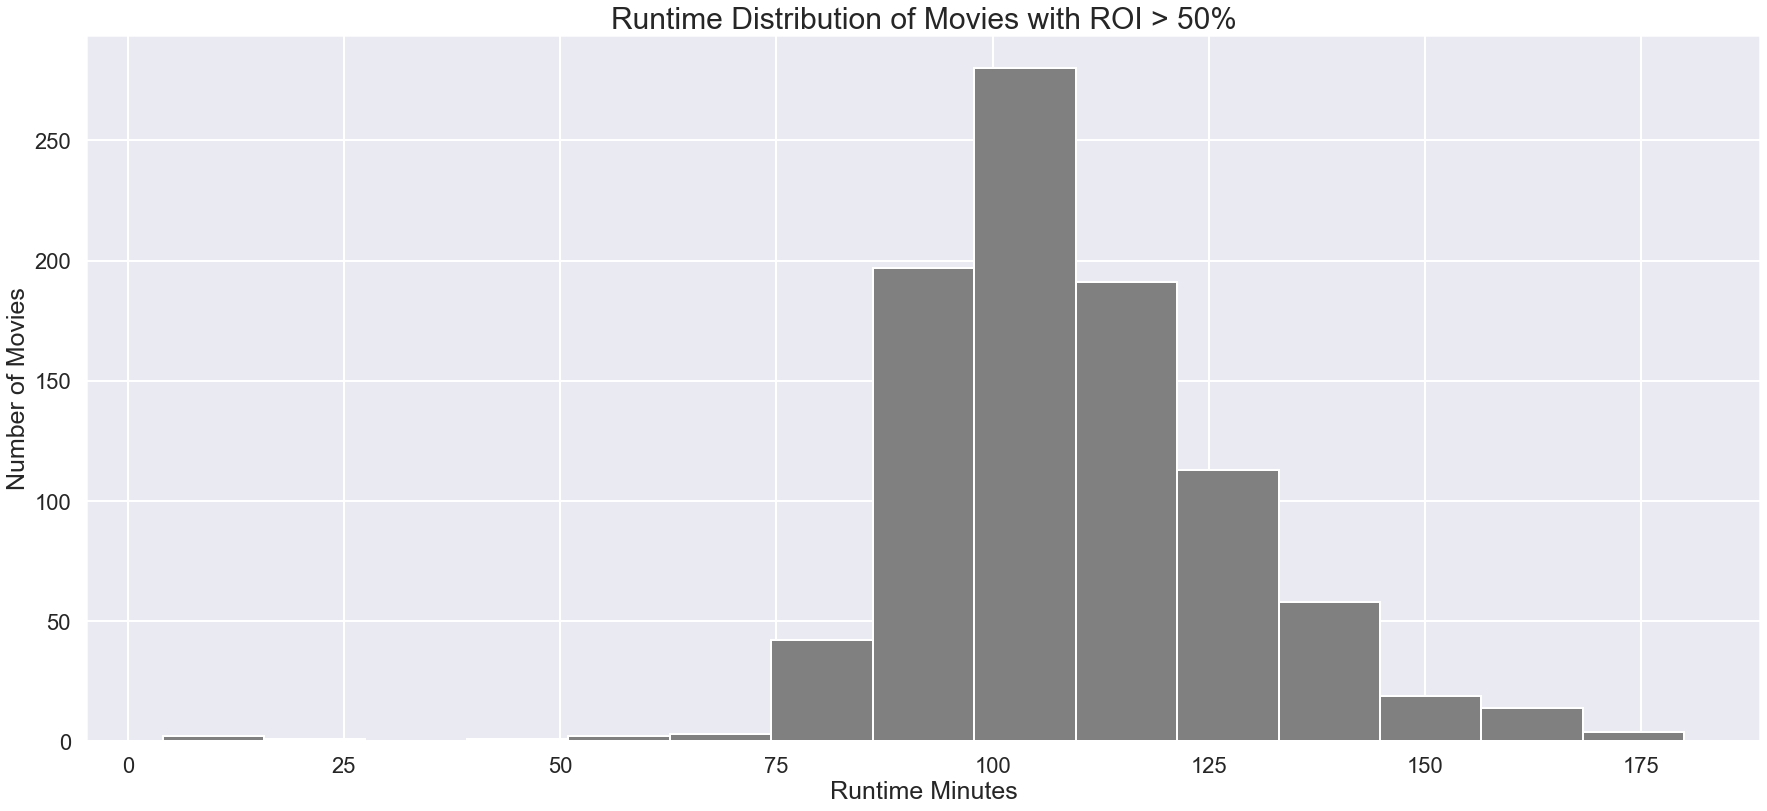

In [20]:
fig, ax = plt.subplots(figsize=(30,13))


ax.hist(numbers_and_tb['runtime_minutes'].loc[(numbers_and_tb['runtime_minutes'] < 250) & (numbers_and_tb['ROI_perc'] > 50)], bins=15, color='grey')

ax.tick_params(axis="x")
ax.set_xlabel("Runtime Minutes", fontsize=25)
ax.set_ylabel("Number of Movies", fontsize=25)
ax.set_title("Runtime Distribution of Movies with ROI > 50%", fontsize=30);

### Top Studios by Profit Margin
The graphs below show the top 10 studios by profit margin. 
* Left Graph: Domestic Profit Margin
* Right Graph: Worldwide Profit Margin

<ipython-input-21-55dc0a8102c2>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(labels=avg_studio['studio'], fontsize=30)
<ipython-input-21-55dc0a8102c2>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(labels=avg_studio['studio'], fontsize=30);


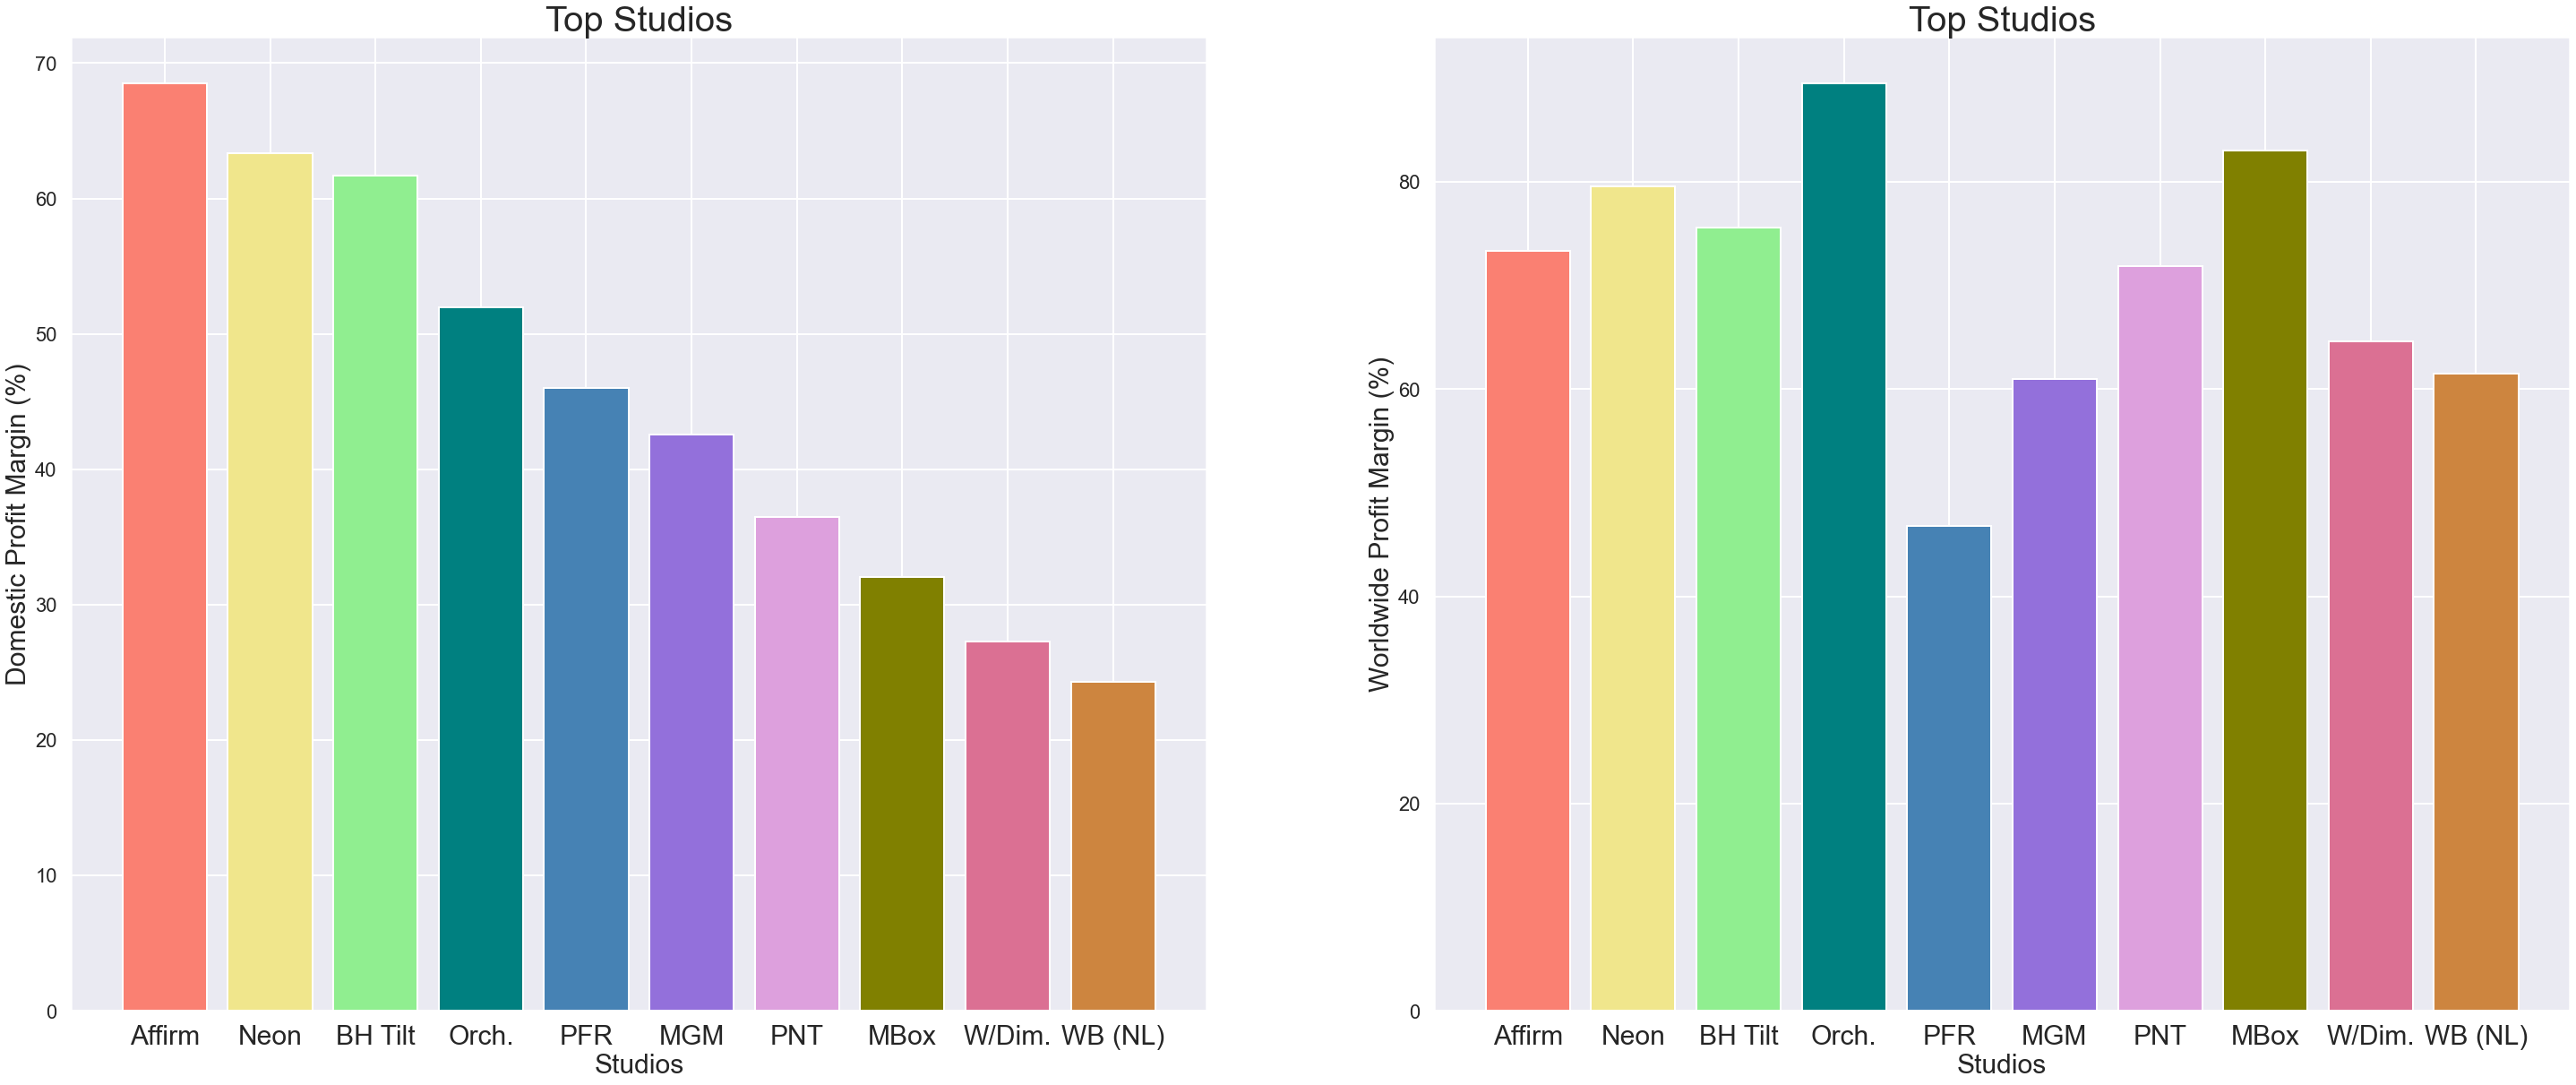

In [21]:
avg_studio = avg_studio.sort_values('dom_profit_margin', ascending=False).iloc[:10]

fig, axs= plt.subplots(figsize=(50,20), ncols=2)

axs[0].bar(avg_studio['studio'], avg_studio['dom_profit_margin'],
          color=['salmon', 'khaki', 'lightgreen', 'teal', 'steelblue', 'mediumpurple', 'plum', 'olive', 'palevioletred', 'peru'])
axs[1].bar(avg_studio['studio'], avg_studio['ww_profit_margin'],
          color=['salmon', 'khaki', 'lightgreen', 'teal', 'steelblue', 'mediumpurple', 'plum', 'olive', 'palevioletred', 'peru'])

axs[0].set_title('Top Studios', fontsize=40)
axs[0].set_xlabel('Studios', fontsize=30)
axs[0].set_ylabel('Domestic Profit Margin (%)', fontsize=30)
axs[0].set_xticklabels(labels=avg_studio['studio'], fontsize=30)

axs[1].set_title('Top Studios', fontsize=40)
axs[1].set_xlabel('Studios', fontsize=30)
axs[1].set_ylabel('Worldwide Profit Margin (%)', fontsize=30)
axs[1].set_xticklabels(labels=avg_studio['studio'], fontsize=30);

### Movie Profit by Month of Release

The graphs show average profit by month (left) a film was released and average ROI by month (right) film was released.
The first set of graphs is specific to only the Horror genre, while the second set of graphs is industry wide data. The averages are computed as the median average of the films released from year 2000 to 2020. 

In [22]:
# Graphing Parameters
month = month_df['month_name']
profit_amount = month_df['world_wide_profit_amount']
ROI = month_df['ROI_perc']
wwgross = month_df['worldwide_gross']

# Horror Specific
month_horror = horror_month_df['month']
profit_amount_horror = horror_month_df['world_wide_profit_amount']
ROI_horror = horror_month_df['ROI_perc']
wwgross_horror = horror_month_df['worldwide_gross']

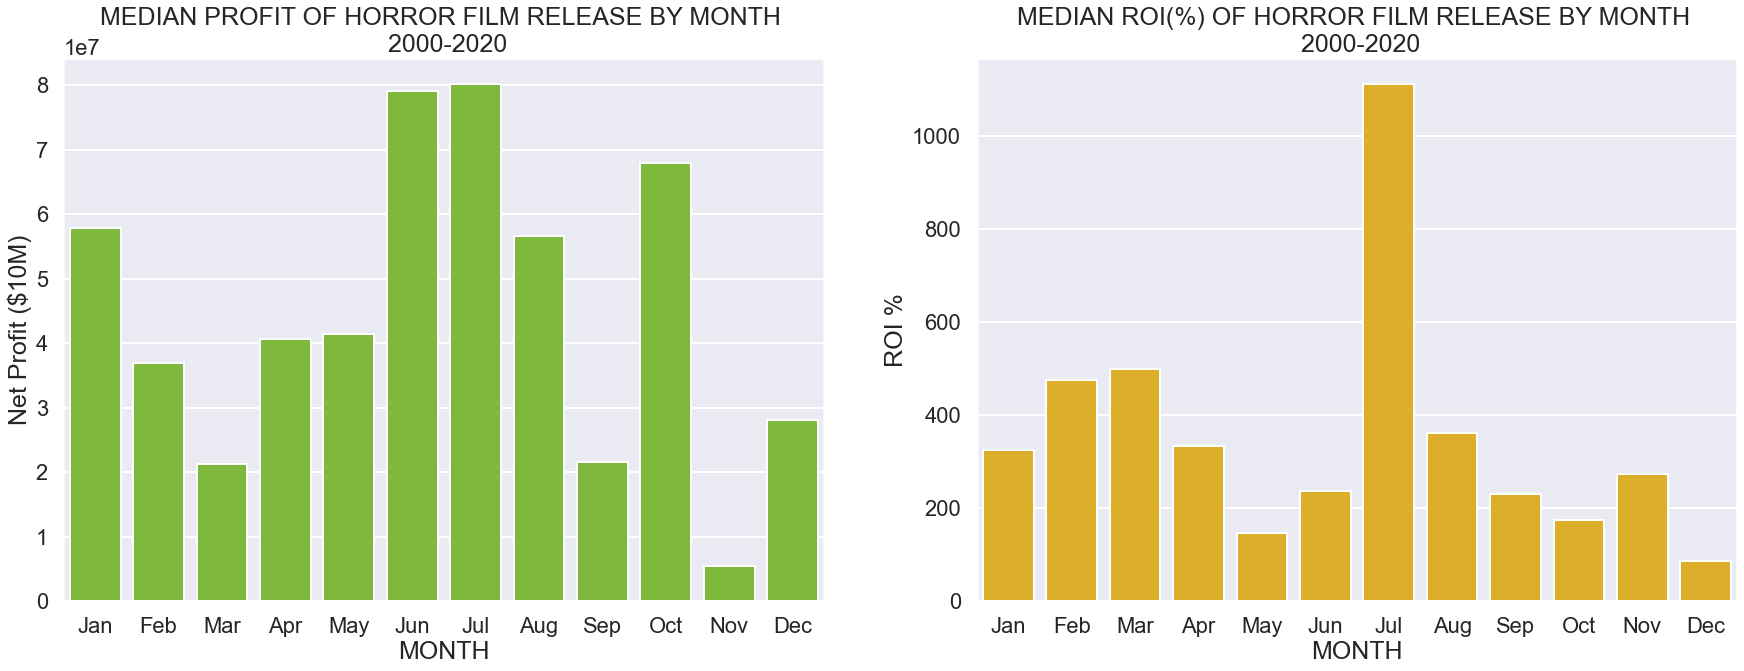

In [23]:
fig, axs = plt.subplots(figsize=(30,10), ncols=2)

sns.barplot(x=month, y=profit_amount_horror, ax=axs[0], color='#7fcc28')
sns.barplot(x=month, y=ROI_horror, ax=axs[1], color='#fabc0b')

axs[0].set_xlabel('MONTH', fontsize=25)
axs[0].set_ylabel('Net Profit ($10M)', fontsize=25)
axs[0].set_title(label='MEDIAN PROFIT OF HORROR FILM RELEASE BY MONTH \n 2000-2020', fontsize=25)

axs[1].set_xlabel('MONTH', fontsize=25)
axs[1].set_ylabel('ROI %', fontsize=25)
axs[1].set_title(label='MEDIAN ROI(%) OF HORROR FILM RELEASE BY MONTH \n 2000-2020', fontsize=25);

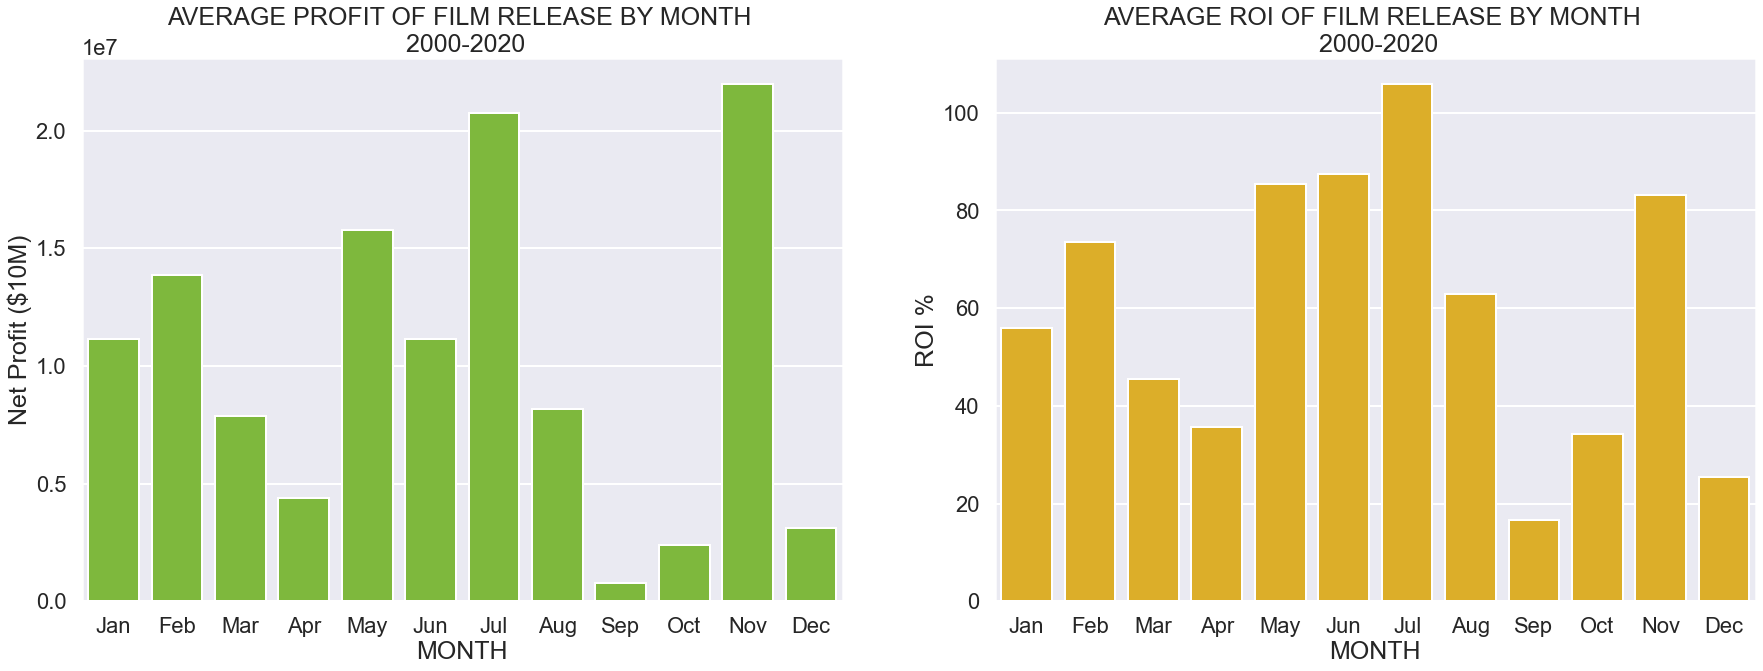

In [24]:
fig, axs = plt.subplots(figsize=(30,10), ncols=2)

sns.barplot(x=month, y=profit_amount, ax=axs[0], color='#7fcc28')
sns.barplot(x=month, y=ROI, ax=axs[1], color='#fabc0b')
sns.set_context('poster')

axs[0].set_xlabel('MONTH', fontsize=25)
axs[0].set_ylabel('Net Profit ($10M)', fontsize=25)
axs[0].set_title(label='AVERAGE PROFIT OF FILM RELEASE BY MONTH \n 2000-2020', fontsize=25)

axs[1].set_xlabel('MONTH', fontsize=25)
axs[1].set_ylabel('ROI %', fontsize=25)
axs[1].set_title(label='AVERAGE ROI OF FILM RELEASE BY MONTH \n 2000-2020', fontsize=25);

### Film Genres Frequently Released

The graph shows the total frequency of releases by genre for each film over the years 2000 - 2020 from The Numbers and TMDb datasets. 

Given the frequency of the genres released tells a few things:
 - what genres other studio are typically releasing
 - how competitive the genres are

It is worth considering what genres our competitors are releasing often. For example, drama movies are released the most, so Microsoft would have to release a drama film that sets it apart from the others.

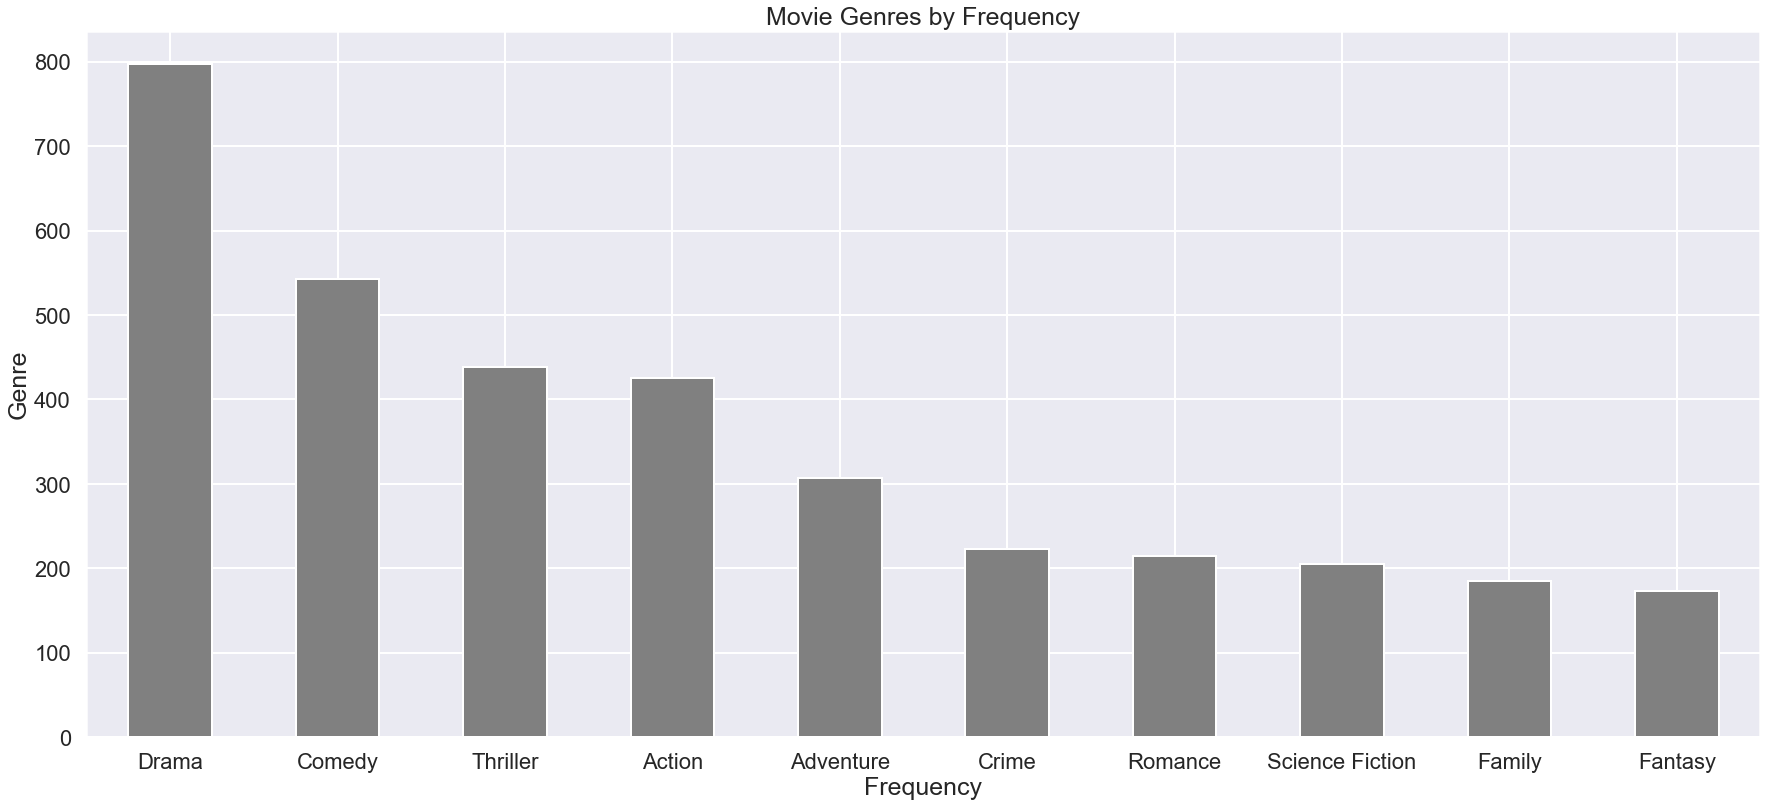

In [25]:
fig, ax = plt.subplots(figsize=(30,13))

genre_overall['genre_name'].value_counts()[:10].plot(kind='bar', color='grey')
plt.xticks(rotation=0)
ax.set_xlabel('Frequency', fontsize=25)
ax.set_ylabel('Genre', fontsize=25)
ax.set_title('Movie Genres by Frequency', fontsize=25);

### Return on Investment (ROI) by Genres

We can see that horror films have an extremely high ROI while music and science fiction have the lowest returns. The graph shows the mean return on investment (in percent) for each film genre over the years 2000-2020 from the The Numbers and TMDb datasets. 

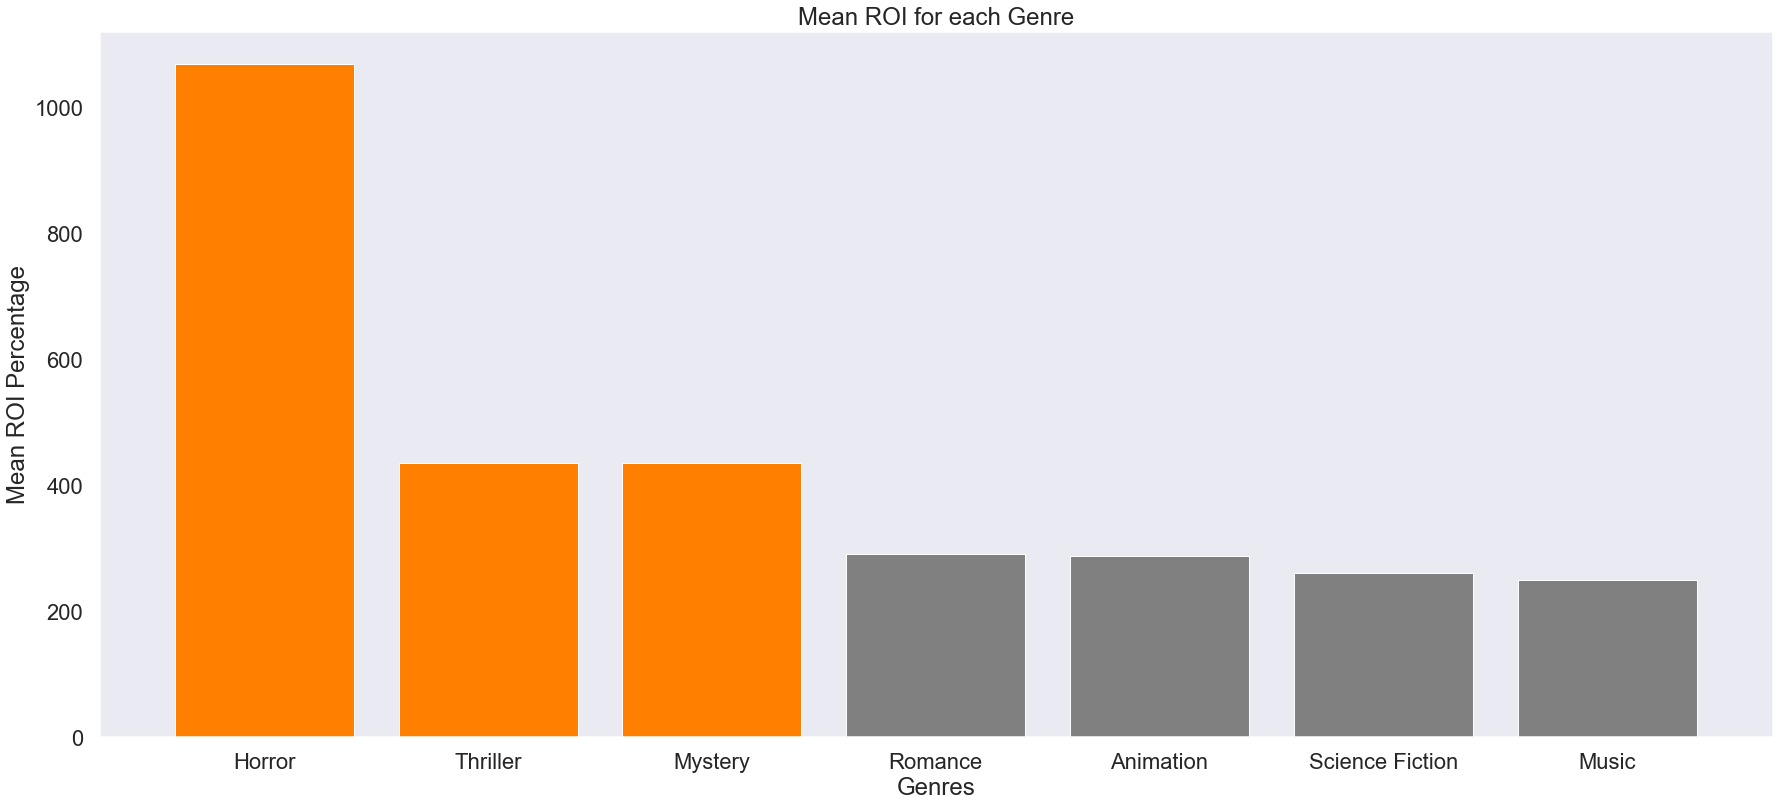

In [26]:
fig, ax= plt.subplots(figsize=(30,13))

sns.set(font_scale=2)
ax.bar(genre_groups.index, 'ROI_perc', data=genre_groups, color=['#ff7f00', '#ff7f00', '#ff7f00', 'grey', 'grey', 'grey', 'grey'])
ax.set_title("Mean ROI for each Genre")
ax.set_xlabel("Genres")
ax.set_ylabel("Mean ROI Percentage")
ax.grid(False);

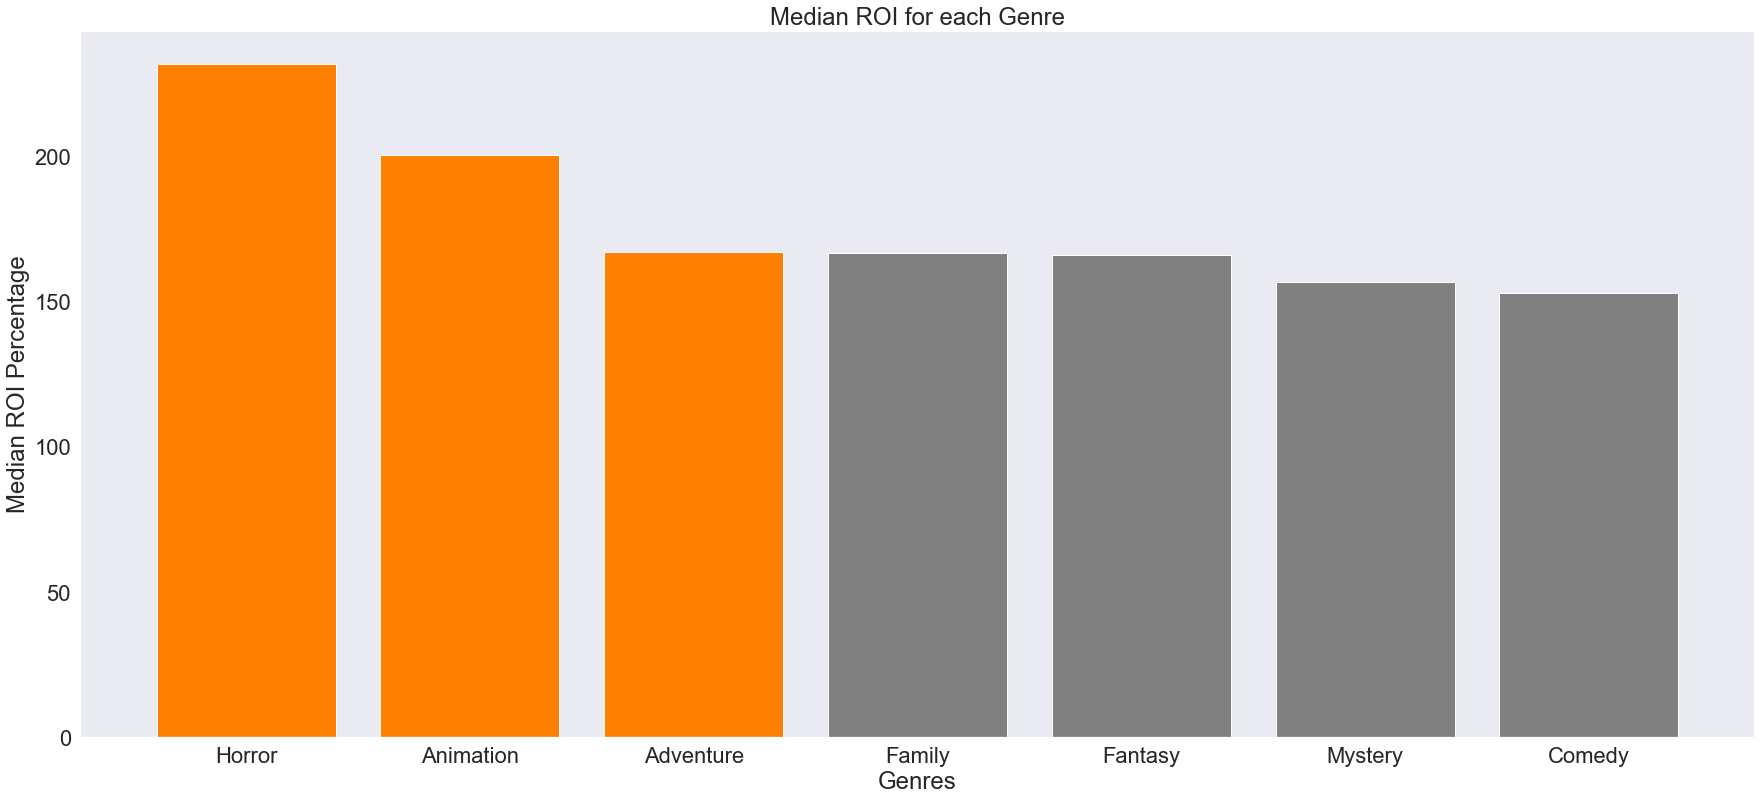

In [27]:
fig, ax= plt.subplots(figsize=(30,13))


sns.set(font_scale=2)
ax.bar(genre_groups_med.index, 'ROI_perc', data=genre_groups_med, color=['#ff7f00', '#ff7f00', '#ff7f00', 'grey', 'grey', 'grey', 'grey'] )
ax.set_title("Median ROI for each Genre")
ax.set_xlabel("Genres")
ax.set_ylabel("Median ROI Percentage")
ax.grid(False);

### Profit Counts
The graphs below show counts of a film being profitable or not profitable by genre from 2000-2020.

In [28]:
genre_overall['is_ww_profit'] = genre_overall['ww_profit_margin'] > 0
genre_overall['is_dom_profit'] = genre_overall['dom_profit_margin'] > 0

In [29]:
horror_profit = genre_overall[genre_overall['genre_name'] == 'Horror'].value_counts('is_ww_profit')
thirller_profit = genre_overall[genre_overall['genre_name'] == 'Thriller'].value_counts('is_ww_profit')
mystery_profit = genre_overall[genre_overall['genre_name'] == 'Mystery'].value_counts('is_ww_profit')
adventure_profit = genre_overall[genre_overall['genre_name'] == 'Adventure'].value_counts('is_ww_profit')
animation_profit = genre_overall[genre_overall['genre_name'] == 'Animation'].value_counts('is_ww_profit')

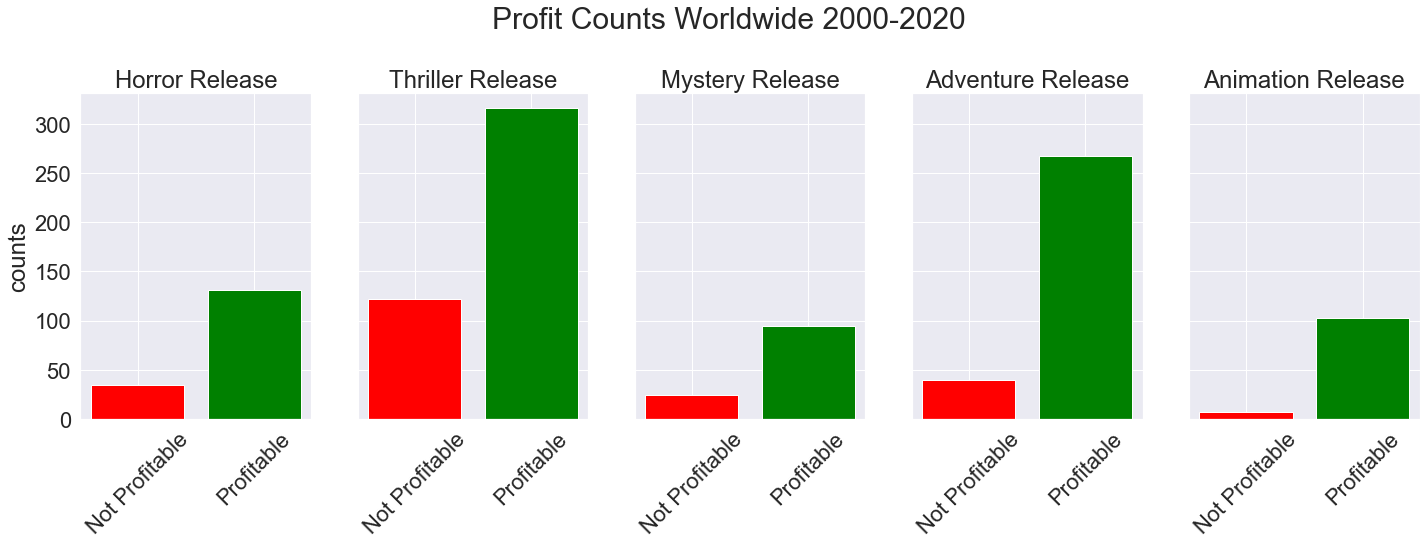

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(24, 6), ncols=5, sharey=True)

sns.set(font_scale=2)

ax1.bar(x=horror_profit.index, height=horror_profit, color=['green', 'red'])
ax2.bar(x=thirller_profit.index, height=thirller_profit, color=['green', 'red'])
ax3.bar(x=mystery_profit.index, height=mystery_profit, color=['green', 'red'])
ax4.bar(x=adventure_profit.index, height=adventure_profit, color=['green', 'red'])
ax5.bar(x=animation_profit.index, height=animation_profit, color=['green', 'red'])

ax1.set_ylabel('counts')
ax1.set_title('Horror Release')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Not Profitable', 'Profitable'], rotation=45)
ax2.set_title('Thriller Release')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Not Profitable', 'Profitable'], rotation=45)
ax3.set_title('Mystery Release')
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Not Profitable', 'Profitable'], rotation=45)
ax4.set_title('Adventure Release')
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['Not Profitable', 'Profitable'], rotation=45)
ax5.set_title('Animation Release')
ax5.set_xticks([0, 1])
ax5.set_xticklabels(['Not Profitable', 'Profitable'], rotation=45)
fig.suptitle('Profit Counts Worldwide 2000-2020', fontsize=30, verticalalignment='top', y=1.08);

## Conclusions

This analysis leads to three recommendations for Microsoft when creating a movie studio:

- __Don't make cliffhangers or movies too long.__ Runtime for movies should be made between 90-120 minutes; movies with ROI above 50% were made in this range. Avoid producing movie runtimes out of this recommened range improve ROI.
- __Acquire Neon or Orchard Film Studios.__ Both Neon and Orchard are ranked highly in profits for both domestic and worldwide markets. Acquiring either one of these two would allow Microsoft to make movies that are competitive in the box office. 
- __Create films with a historically high ROI:__ *Horror* (release in June, July, and October), *Mystery* & *Thriller* with considerations to low risk films: *Adventure* & *Animation*. Adding these genres as part of the production portfolio would garner Microsoft a higher return on investment.

### Next Steps

Further analyses could provide additional insights to having a more successful movie studio for Microsoft:

- __Net Profit to Studio Data.__ As of now we are seeing the net profit of the film at box office but not what profits are returning directly to the studios involved. Having the net profit by film to studio would increase the strength of our analysis of when to release movies.
- __Other expense data.__ Further inspection to types of expense could also help for your capital budgeting. E.g. marketing expense, distribution expense, etc.
- __Competitors' financial performance.__ Deeper understanding of competitive landscape — to have organized data on competitors financial performance would help strengthen our M&A recommendations. E.g. historical market cap data
- __Straight to streaming and licensing.__ Although the box office is important for new films, much the data had $0 box office gross which led us to believe some films sell straight to streaming licensing. Exploring data related to streaming and licensing would also provide a realistic prediction of how a film could be exploited. 